In [66]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from diffNN import *
import sys
sys.path.insert(0, '/Users/tk/Documents/GitHub/Speciale/rBergomi')
from rBergomi import roughBergomi
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Simulating training set:   0%|          | 0/8192 [00:00<?, ?it/s]

Training differential neural network... 
Training completed in 2.79 seconds


Simulating test set:   0%|          | 0/100 [00:00<?, ?it/s]

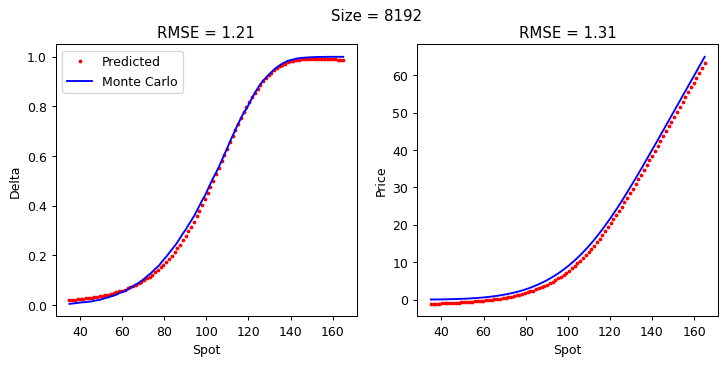

In [67]:
model = create_graph()

n_epochs = 100 
size = 2 ** 17
batch_size = int(max(256, size // 16))

T = 1 
H = 0.1
eta = 1
rho = -.3,
xi = 0.235**2
spot = 1.0
strike = 1.0

rB = roughBergomi(n_paths = size, n_steps = 52, T=T,
                    H=H, eta=1, rho=rho, xi=xi, spot=spot, strike=strike)
volterra, W, dW = rB.simulate_paths()
V = rB.simulate_V(volterra)
xTrain, yTrain, dydxTrain = rB.payoff_delta(V, dW)

x_mean, x_std, x, y_mean, y_std, y, dydx, lambda_j = normalize_data(xTrain, yTrain, dydxTrain)

optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule(n_epochs, size, batch_size))
model.compile(loss=['mse', create_derivsLoss(lambda_j)], optimizer=optimizer)

print('Training differential neural network... ')
t0 = time.time()
history = model.fit(
    x, [y, dydx], epochs=n_epochs, batch_size = batch_size, verbose = 0
)
t1 = time.time()
print('Training completed in {} seconds'.format(round(t1-t0, 2)))

xTest, yTest, dydxTest = rB.test(V, dW)
x_scaled = (xTest - x_mean) / x_std
y_scaled, dydx_scaled = model.predict(x_scaled)
yPred = y_mean + y_std * y_scaled
dydxPred = y_std / x_std * dydx_scaled

plot_value_delta(xTest, yPred, yTest, dydxPred, dydxTest, size)